<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

### Anaconda installation

In [1]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

#!pip install keras_sequential_ascii

  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp36-none-any.whl size=3061 sha256=c87771edd101d6e26493fc59efe21e27233f3bd013f04320b9187241469a1a73
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


### Dependencies

In [2]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras_sequential_ascii import keras2ascii

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(0)

Using TensorFlow backend.


### Functions

In [0]:
def plot_eval(model):
    
    plt.rcParams["figure.figsize"] = (18,6)
    fig, ax = plt.subplots()
    
    c = 'blue'                                   # train -- blue
    ax.scatter(y_train, model.predict(x_train),
               s=65, c=c, zorder=10, edgecolors='k')
    c = 'red'                                    # tests -- red
    ax.scatter(y_test,  model.predict(x_test),
               s=65, c=c, cmap=plt.cm.coolwarm, 
               zorder=10, edgecolors='k')
    
    ax.set_xlabel("pIC50 experimental", fontsize=16)
    ax.set_ylabel("pIC50 prediction",   fontsize=16)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # integer limits
    ilims = [int(x+0.5) for x in lims]
    ax.set_xticks(np.arange(*ilims,2))
    ax.set_yticks(np.arange(*ilims,2))
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

In [0]:
def plot_valid(models, titles):
    
    fig, axes = plt.subplots(2, 2, sharey=True)
    
    i = 0
    a = 0
    b = 0
    
    for model in models:
        
        a  = int(i%2)
        b  = int(i/2)
        ax = axes[a, b]
        
        ax.title.set_text(titles[i])
        i += 1
        
        c = vy.astype(int)
        ax.scatter(vy,  model.predict(vx),
                   s=65, c=c, cmap=plt.cm.coolwarm, 
                   zorder=10, edgecolors='k')
        
        ax.set_xlabel("pIC50 experimental", fontsize=16)
        ax.set_ylabel("pIC50 prediction",   fontsize=16)
        
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # integer limits
        ilims = [int(x+0.5) for x in lims]
        ax.set_xticks(np.arange(*ilims,2))
        ax.set_yticks(np.arange(*ilims,2))
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
    plt.show()

In [0]:
def normalize(x):
    x = (x - x.mean(axis=0))
    y = x.std(axis=0)
    y[y==0] = 1
    return x/y

## <font color='green'>Data Processing</font>

### Read IC50 data

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log(float(x)))

# drop Ipc
datasets = datasets.drop(['Ipc'], axis=1)
cols.remove('Ipc')

Check features.

In [6]:
corr = datasets.corr()
corr.loc[(corr['pIC50'] >= 0.4) | (corr['pIC50'] <= -0.4)]['pIC50'][1:]

qed                        0.491180
MolWt                     -0.526664
BertzCT                   -0.503721
PEOE_VSA1                 -0.450455
PEOE_VSA3                 -0.465307
SMR_VSA1                  -0.427446
SlogP_VSA2                -0.509821
TPSA                      -0.533955
EState_VSA2               -0.467875
VSA_EState9               -0.454508
NOCount                   -0.529112
NumAromaticHeterocycles   -0.400436
NumHAcceptors             -0.487935
NumHeteroatoms            -0.593323
NumRotatableBonds         -0.463759
fr_Ar_COO                 -0.486644
f_111                     -0.478565
f_186                     -0.459100
f_456                     -0.492155
f_667                      0.419061
f_807                     -0.456968
f_1242                    -0.411416
f_1403                    -0.471330
f_1601                    -0.400506
f_1634                     0.420678
f_2147                    -0.470485
f_2238                    -0.471330
f_2287                    -0

### Splitting

Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
# Input and Output
y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

# S: qualifiers classification
s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# CUTOFFS: > greater
rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# CUTOFFS: < lower
lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

In [0]:
# split dataset and update \
# qualifiers S and CUTOFFS

f = np.vstack((x.T, lcutoff, rcutoff, s1, s2, s0)).T
f_train, f_test, y_train, y_test = train_test_split(f, y, test_size=0.25, random_state=42)

x_train = f_train[:,:-5]
x_test  = f_test[:,:-5]

s0_train = f_train[:,-1]
s2_train = f_train[:,-2]
s1_train = f_train[:,-3]
rcutoff_train = f_train[:,-4]
lcutoff_train = f_train[:,-5]

# Normalized features
# x - mean / std
x_train = normalize(x_train)
x_test  = normalize(x_test) 

## <font color='green'>Neural Network</font>

A simple Fully Connected Neural Network

### <font color='blue'>LOSS FUNCTION (with censored data)</font>

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_train
    l = y_pred - lcutoff_train
    # qualifiers adjusted Loss function
    return K.mean((1-s0_train)*K.square(z) + s2_train*K.relu(-r) + s1_train*K.relu(l), axis=-1)

### Fully Connected Net

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=50, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    # hidden layer
    model.add(Dense(units=25))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network = None 
network = create_model(input_dim) 

In [49]:
# Visulaize
keras2ascii(network)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         588
               Dense   XXXXX -------------------     29450    87.4%
                       #####          50
             Dropout    | || -------------------         0     0.0%
                relu   #####          50
  BatchNormalization    μ|σ  -------------------       200     0.6%
                       #####          50
               Dense   XXXXX -------------------      2550     7.6%
                       #####          50
             Dropout    | || -------------------         0     0.0%
                relu   #####          50
  BatchNormalization    μ|σ  -------------------       200     0.6%
                       #####          50
               Dense   XXXXX -------------------      1275     3.8%
                relu   #####          25
               Dense   XXXXX -------------------        26     0.1%
                       #####           1


### Run Lola, Run

Parameters are not optimized! No Grid search.

In [0]:
%%capture

# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=60,                       # Number of epochs
                      verbose=0,                        # No output
                      batch_size=20,                    # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [14]:
network.save("/content/network.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>


In [0]:
#network = None
#network = create_model(x.shape[1])
#network.load_weights('/content/network.h5')

### Optimization

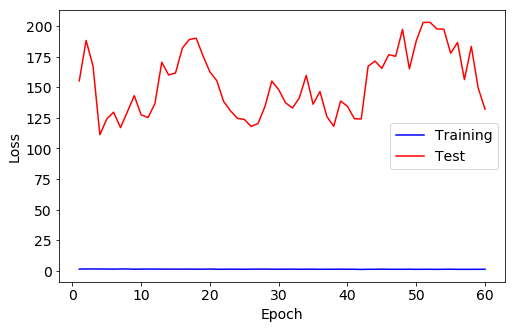

In [56]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
#plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Plot prediction vs experiment

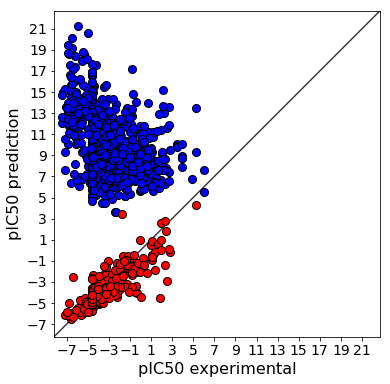

In [59]:
plot_eval(network)

### Statistics

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8025141287519624
MAE         : 0.9624507752364377
Kendall Tau : 0.6615499287341644


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    # finished
    
    network = None
    network = create_model(x_test.shape[1]) 
    network.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.8025672916939779
MAE         : 0.9672140810400226
Kendall Tau : 0.6554938030979074
#------------------------#
R2          : 0.7944269215319234
MAE         : 1.0272374453075683
Kendall Tau : 0.6481234310085822
#------------------------#
R2          : 0.801356082982084
MAE         : 1.190037945438198
Kendall Tau : 0.6419207296355144
#------------------------#
R2          : 0.8467108955050646
MAE         : 0.9085927364028987
Kendall Tau : 0.7052902666485624


## <font color='green'>Linear Model</font>

A strightforward linear regression model.

### Single Layer Net

In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
input_dim = x.shape[1]

# Clearing the LM
shallow = None 
shallow = create_linear(input_dim)                      # model

### Rum, Rum

In [0]:
# Train shallow model
history = shallow.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [75]:
shallow.save("/content/shallow.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#shallow = None
#shallow = create_linear(x.shape[1])
#shallow.load_weights('/content/shallow.h5')

### Plot prediction vs experiment

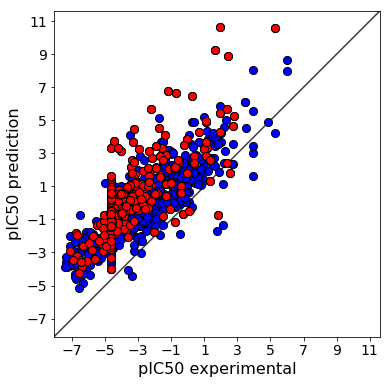

In [76]:
plot_eval(shallow)

### Statistics

In [77]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7619747913209157
MAE         : 3.6619392596454396
Kendall Tau : 0.5827915000306808


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    # finished
    
    shallow = None 
    shallow = create_model(x_test.shape[1])
    shallow.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7590643526511062
MAE         : 1.0051011234400964
Kendall Tau : 0.6004703474128602
#------------------------#
R2          : 0.8189774513737222
MAE         : 1.0256675506185124
Kendall Tau : 0.6736795315545593
#------------------------#
R2          : 0.8091950954493399
MAE         : 1.0051678487371396
Kendall Tau : 0.6696106133683092
#------------------------#
R2          : 0.8372640051616529
MAE         : 0.9120964108806795
Kendall Tau : 0.6654698497282378


## <font color='green'>Control FCNN</font>

Repeat the previous methods but ignore censored data

### <font color='blue'>LOSS FUNCTION (without censored data)</font>

In [0]:
def normal_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_train
    l = y_pred - lcutoff_train
    # Loss function
    return K.mean((1-s0_train)*K.square(z), axis=-1)

### Fully Connected Neural Network

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=50, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # hidden layer
    model.add(Dense(units=50))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    # hidden layer
    model.add(Dense(units=25))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=normal_loss,                     # Normal loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network2 = None 
network2 = create_model(input_dim) 

### Corre Lolita

In [0]:
%%capture

# Train neural network
history = network2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       batch_size=50,                    # Number of observations per batch
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [81]:
network2.save("/content/network2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#network2 = None
#network2 = create_model(x.shape[1])
#network2.load_weights('/content/network2.h5')

### Evaluation

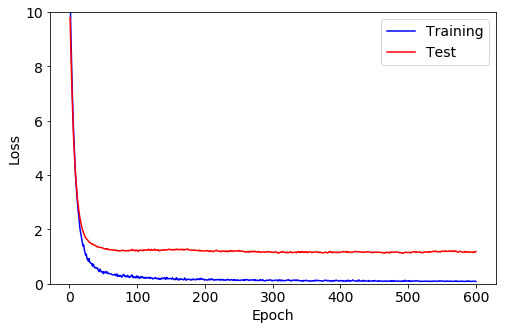

In [82]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions versus Experiments

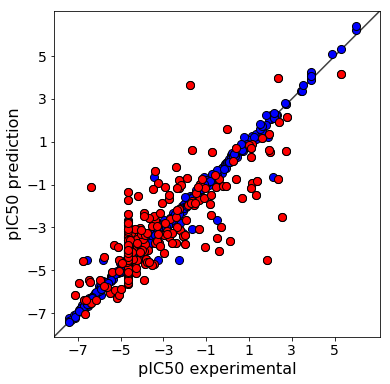

In [83]:
plot_eval(network2)

### Statistics

In [84]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8027866820720837
MAE         : 0.9092952345848425
Kendall Tau : 0.6156307035183524


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    # finished
    
    network2 = None
    network2 = create_model(x_test.shape[1]) 
    network2.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7747791704112131
MAE         : 0.9361056620998873
Kendall Tau : 0.6364125290583261
#------------------------#
R2          : 0.8274958997422772
MAE         : 0.9859454889528977
Kendall Tau : 0.6759588594410924
#------------------------#
R2          : 0.8222709627567668
MAE         : 0.9802594074410274
Kendall Tau : 0.6712720063922768


KeyboardInterrupt: ignored

## <font color='green'>Control LM</font>

### Single Layer Net



In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=normal_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
# Clearing the LM
shallow2 = None 
shallow2 = create_linear(input_dim)                      # model

### Jogging

In [0]:
# Train shallow model
history = shallow2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [88]:
shallow2.save("/content/shallow2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#shallow2 = None
#shallow2 = create_linear(x.shape[1])
#shallow2.load_weights('/content/shallow2.h5')

### Predictions versus Experiments

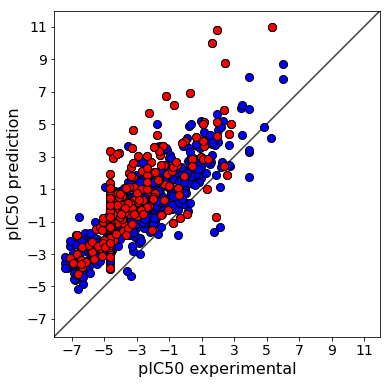

In [89]:
plot_eval(shallow2)

### Statistics

In [90]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.764294081315828
MAE         : 3.6514596564706987
Kendall Tau : 0.5812608591901537


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    # finished
    
    shallow2 = None 
    shallow2 = create_model(x_test.shape[1])
    shallow2.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

## <font color='green'>Validation</font>

External dataset from BindingDB for DNA Gyrase

### Data Processing

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/BindingDB_Gyrase_B_features.tsv"
validset = pd.read_csv(filepath)

# Rename columns
validset.rename(columns={'IC50':'pIC50'}, inplace=True)
validset.rename(columns={'Ligand SMILES':'Molecule SMILES'}, inplace=True)

# Modify dataset
validset['pIC50'] = validset['pIC50'].apply(lambda x: np.log(float(x)))
validset = validset.drop(['Ipc'], axis=1)

# New columns
pattern = "[<]"
filters = validset.Censorship.str.contains(pattern)
validset["left_saturated"] = filters

pattern = "[>]"
filters = validset.Censorship.str.contains(pattern)
validset["right_saturated"] = filters

# Reorder dataframe
cols = validset.columns.tolist()
cols = cols[:1] + cols[-4:] + cols[1:-4]
validset = validset[cols]

# Reorder dataframe
validset = validset[list(datasets.columns)]

# Remove SMILES
validset = validset[~validset['Molecule SMILES'].isin(datasets['Molecule SMILES'].values)]

In [0]:
# input and output
vy = validset['pIC50'].copy()
vy = vy.astype('float64').to_numpy()

vx = validset.iloc[:,4:].copy()
vx = vx.astype('float64').to_numpy()

# Normalized features
##### x = (x - x.mean(axis=0)) / x.std(axis=0)
vx = (vx - vx.mean(axis=0))
t = vx.std(axis=0)
t[t==0] = 1
vx = vx/t

### Plot pIC50 predictions

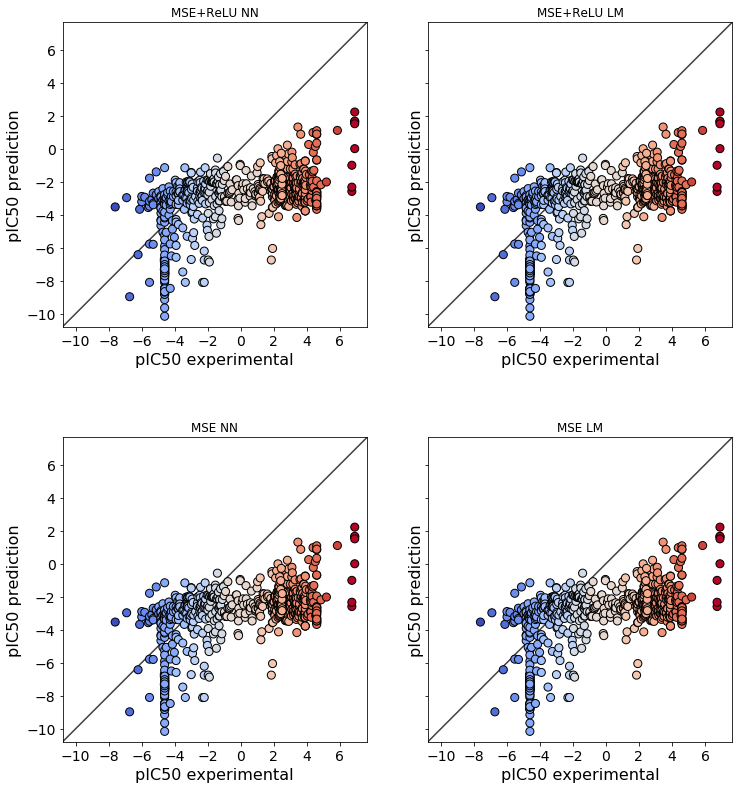

In [32]:
#models = [network, network2, shallow, shallow2]
models = [network, network, network, network]
titles = ['MSE+ReLU NN','MSE NN','MSE+ReLU LM','MSE LM']

plt.rcParams["figure.figsize"] = (12,14)
plot_valid(models, titles)

### Statistical Performance

In [112]:
labels = ['MSE+ReLu NN', 'MSE NN', 'MSE+ReLu LM', 'MSE LM']

i = 0
for name in [network, network2, shallow, shallow2]:
    
    slope, intercept, r_value, p_value, std_err = linregress(y, name.predict(x)[:,0])
    tau, p_value                                = kendalltau(y, name.predict(x)[:,0])
    rho, p_value                                = spearmanr(y, name.predict(x)[:,0])
    mae                                         = mean_absolute_error(y, name.predict(x)[:,0])
    mse                                         = mean_squared_error(y, name.predict(x)[:,0])
    
    print("##### METHOD: %s" % labels[i])
    print("Kendall Tau : %s" % tau)
    print("R2          : %s" % r_value)
    print("Spearman    : %s" % rho)
    print("MAE         : %s" % mae)
    print("RMSE        : %s" % np.sqrt(mse))
    print("")
    
    i+=1

##### METHOD: MSE+ReLu NN
Kendall Tau : 0.3491893941172285
R2          : 0.5116587536100686
Spearman    : 0.49155385491911424
MAE         : 3.130840829978039
RMSE        : 4.047032183121021

##### METHOD: MSE NN
Kendall Tau : 0.28329378983791614
R2          : 0.48048699111628707
Spearman    : 0.4088633150426709
MAE         : 3.2896546533948605
RMSE        : 3.9033122590152174

##### METHOD: MSE+ReLu LM
Kendall Tau : 0.3662710432557008
R2          : 0.5646467200381357
Spearman    : 0.5276464753225477
MAE         : 2.432934938444565
RMSE        : 2.9365478575078368

##### METHOD: MSE LM
Kendall Tau : 0.3505296750290675
R2          : 0.5490561754665058
Spearman    : 0.501702230286471
MAE         : 2.499125423343754
RMSE        : 3.006921042235247

